## Load Libraries and Create Function

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.externals import joblib
%matplotlib inline

In [2]:
class BinaryClassificationPerformance():
    '''Performance measures to evaluate the fit of a binary classification model'''
    
    def __init__(self, predictions, labels, desc, probabilities=None):
        '''Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y'''
        '''probabilities-optional, probability that Y is equal to True'''
        self.probabilities = probabilities
        self.performance_df = pd.concat([pd.DataFrame(predictions), pd.DataFrame(labels)], axis=1)
        self.performance_df.columns = ['preds', 'labls']
        self.desc = desc
        self.performance_measures = {}
  
    def compute_measures(self):
        '''Compute performance measures defined by Flach p. 57'''
        self.performance_measures['Pos'] = self.performance_df['preds'].sum()
        self.performance_measures['Neg'] = self.performance_df.shape[0] - self.performance_df['preds'].sum()
        self.performance_measures['TP'] = ((self.performance_df['preds'] == True) & (self.performance_df['labls'] == True)).sum()
        self.performance_measures['TN'] = ((self.performance_df['preds'] == False) & (self.performance_df['labls'] == False)).sum()
        self.performance_measures['FP'] = ((self.performance_df['preds'] == True) & (self.performance_df['labls'] == False)).sum()
        self.performance_measures['FN'] = ((self.performance_df['preds'] == False) & (self.performance_df['labls'] == True)).sum()
        self.performance_measures['Accuracy'] = (self.performance_measures['TP'] + self.performance_measures['TN']) / (self.performance_measures['Pos'] + self.performance_measures['Neg'])

In [3]:
amazon = pd.read_csv('raw_data_train.csv', encoding ='latin-1')
print(amazon.shape)

(364000, 14)


In [4]:
print(amazon.head())
print(amazon['helpful'].mean())

   Unnamed: 0  Unnamed: 0.1      Id   ProductId          UserId  \
0      105955        453320  453321  B0029XLH4Y  A3TK05LMKBKPOM   
1       28518        425598  425599  B0034EDMLI  A1I4PIEEZ5Y131   
2      232010         20436   20437  B001BDDTB2  A2K3DB7X56UXLZ   
3      302676        433507  433508  B003M678R2  A39N7H965S8UGB   
4       58563        217374  217375  7310172101  A1V5MY8V9AWUQB   

                      ProfileName  HelpfulnessNumerator  \
0                            Mike                     0   
1      J. Manley "tellitlikeitis"                     0   
2                      JC Chupack                     2   
3                    kittyhoarder                     0   
4  Cheryl Sapper "champagne girl"                     0   

   HelpfulnessDenominator  Score        Time  \
0                       0      5  1291507200   
1                       0      5  1325462400   
2                       2      5  1228089600   
3                       0      5  1338508800   
4 

## Feature Extraction from Natural Language Libraries

In [5]:
# vectorize Bag of Words from review text; as sparse matrix
from sklearn.feature_extraction.text import HashingVectorizer
hv = HashingVectorizer(n_features=2 ** 17, non_negative=True)
X_hv = hv.fit_transform(amazon.Text)
print(X_hv.shape)

(364000, 131072)


In [6]:
joblib.dump(hv, 'hv.pkl') # pickle

['hv.pkl']

In [7]:
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer()
X_tfidf = transformer.fit_transform(X_hv)

joblib.dump(transformer, 'transformer.pkl')

['transformer.pkl']

In [8]:
print(type(X_tfidf))

<class 'scipy.sparse.csr.csr_matrix'>


## Creating Additional Features

In [9]:
import re
from string import punctuation

# length features
amazon['reviewLen'] = amazon['Text'].str.len()
amazon['profileLen'] = amazon['ProfileName'].str.len() 
amazon['summaryLen'] = amazon['Summary'].str.len() 

#count number of reviews made by the same reviewer
amazon['commCount'] = amazon.groupby('ProfileName')['ProfileName'].transform('count')

#Capital letter Features
amazon['profileCaps'] = amazon['ProfileName'][(np.isnan(amazon['profileLen'])) == 0].apply(lambda x: len(re.findall("[A-Z]", x)))
amazon['summaryCaps'] = amazon['Summary'][(np.isnan(amazon['summaryLen'])) == 0].apply(lambda x: len(re.findall("[A-Z]", x)))
amazon['reviewCaps'] = amazon['Text'][(np.isnan(amazon['reviewLen'])) == 0].apply(lambda x: len(re.findall("[A-Z]", x)))

#punctuation features
amazon['profilePunc'] = amazon['ProfileName'][(np.isnan(amazon['profileLen'])) == 0].apply(lambda x: len(list(filter(lambda c: c in punctuation, x))))
amazon['summaryPunc'] = amazon['Summary'][(np.isnan(amazon['summaryLen'])) == 0].apply(lambda x: len(list(filter(lambda c: c in punctuation, x))))
amazon['reviewPunc'] = amazon['Text'][(np.isnan(amazon['reviewLen'])) == 0].apply(lambda x: len(list(filter(lambda c: c in punctuation, x))))

#convert NaN's to 0
amazon['profileLen'][(np.isnan(amazon['profileLen']))] = 0
amazon['summaryLen'][(np.isnan(amazon['summaryLen']))] = 0
amazon['reviewLen'][(np.isnan(amazon['reviewLen']))] = 0
amazon['commCount'][(np.isnan(amazon['commCount']))] = 0
amazon['profileCaps'][(np.isnan(amazon['profileCaps']))] = 0
amazon['summaryCaps'][(np.isnan(amazon['summaryCaps']))] = 0
amazon['reviewCaps'][(np.isnan(amazon['reviewCaps']))] = 0
amazon['profilePunc'][(np.isnan(amazon['profilePunc']))] = 0
amazon['summaryPunc'][(np.isnan(amazon['summaryPunc']))] = 0
amazon['reviewPunc'][(np.isnan(amazon['reviewPunc']))] = 0

#Interactions
amazon['score_count'] = amazon['Score']*amazon['commCount']
amazon['len_count'] = amazon['reviewLen']*amazon['commCount']
amazon['score_len'] = amazon['Score']*amazon['reviewLen']

X_quant_features = amazon[['Score', 'reviewLen', 'Time', 'summaryLen', 'commCount', 'profileCaps', 'profileLen', 
                            'summaryCaps', 'reviewCaps', 'profilePunc', 'summaryPunc', 'reviewPunc', 'score_count', 'len_count', 'score_len']]
print(X_quant_features.head(10))
print(type(X_quant_features))

C:\Users\Julian Bautista\Anaconda3\lib\site-packages\ipykernel\__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Julian Bautista\Anaconda3\lib\site-packages\ipykernel\__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Julian Bautista\Anaconda3\lib\site-packages\ipykernel\__main__.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Julian Bautista\Anaconda3\lib\site-packages\ipykernel\__main__.py:26: SettingWithCopyWarning: 
A value is trying

   Score  reviewLen        Time  summaryLen  commCount  profileCaps  \
0      5        173  1291507200        31.0      168.0          1.0   
1      5        491  1325462400        41.0        4.0          2.0   
2      5       3623  1228089600        94.0       15.0          3.0   
3      5        250  1338508800        23.0        2.0          0.0   
4      5        204  1244764800        27.0        4.0          2.0   
5      5       1279  1337731200        22.0        1.0          0.0   
6      2        308  1329523200         9.0        7.0          0.0   
7      3        780  1339632000        53.0        4.0          2.0   
8      5        175  1295222400        18.0        6.0          2.0   
9      5        509  1326585600        19.0        2.0          0.0   

   profileLen  summaryCaps  reviewCaps  profilePunc  summaryPunc  reviewPunc  \
0         4.0          1.0          15          0.0          0.0          20   
1        26.0          1.0           8          3.0       

C:\Users\Julian Bautista\Anaconda3\lib\site-packages\ipykernel\__main__.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [10]:
from scipy.sparse import csr_matrix, hstack
X_quant_features_csr = csr_matrix(X_quant_features)
X_combined = hstack([X_tfidf, X_quant_features_csr])
X_matrix = csr_matrix(X_combined) # convert to sparse matrix
print(X_matrix.shape)

(364000, 131087)


In [11]:
# feature scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
X = sc.fit_transform(X_matrix)
print(X.shape)

joblib.dump(sc, 'sc.pkl') # pickle

(364000, 131087)


['sc.pkl']

In [12]:
y = amazon['helpful'].values
print(type(y))

<class 'numpy.ndarray'>


## Create Models

In [13]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X, y)
joblib.dump(svm, 'svm.pkl') # pickle

svm_performance = BinaryClassificationPerformance(svm.predict(X), y, 'svm')
svm_performance.compute_measures()
print(svm_performance.performance_measures)

{'Neg': 343391, 'FP': 8370, 'Accuracy': 0.9375961538461538, 'FN': 14345, 'TN': 329046, 'TP': 12239, 'Pos': 20609}


In [14]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log', n_iter=50, alpha=0.00001)
lgs.fit(X, y)
joblib.dump(lgs, 'lgs.pkl') # pickle

lgs_performance = BinaryClassificationPerformance(lgs.predict(X), y, 'lgs')
lgs_performance.compute_measures()
print(lgs_performance.performance_measures)

{'Neg': 342322, 'FP': 8297, 'Accuracy': 0.94093406593406592, 'FN': 13203, 'TN': 329119, 'TP': 13381, 'Pos': 21678}


In [15]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X, y)
joblib.dump(nbs, 'nbs.pkl') # pickle

nbs_performance = BinaryClassificationPerformance(nbs.predict(X), y, 'nbs')
nbs_performance.compute_measures()
print(nbs_performance.performance_measures)

{'Neg': 307430, 'FP': 39690, 'Accuracy': 0.86430219780219775, 'FN': 9704, 'TN': 297726, 'TP': 16880, 'Pos': 56570}


In [16]:
# MODEL: Ridge Regression Classifier
from sklearn import linear_model
rdg = linear_model.RidgeClassifier()
rdg.fit(X, y)
joblib.dump(rdg, 'rdg.pkl') # pickle

rdg_performance = BinaryClassificationPerformance(rdg.predict(X), y, 'rdg')
rdg_performance.compute_measures()
print(rdg_performance.performance_measures)

{'Neg': 355535, 'FP': 542, 'Accuracy': 0.94724450549450545, 'FN': 18661, 'TN': 336874, 'TP': 7923, 'Pos': 8465}


In [17]:
# MODEL: Perceptron
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X, y)
joblib.dump(prc, 'prc.pkl') # pickle

prc_performance = BinaryClassificationPerformance(prc.predict(X), y, 'prc')
prc_performance.compute_measures()
print(prc_performance.performance_measures)

{'Neg': 334947, 'FP': 14790, 'Accuracy': 0.92551923076923082, 'FN': 12321, 'TN': 322626, 'TP': 14263, 'Pos': 29053}


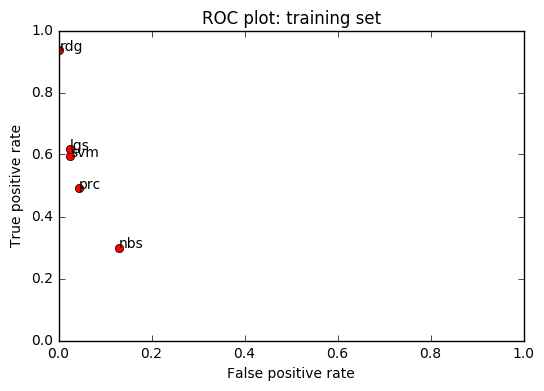

In [18]:
fits = [svm_performance, lgs_performance, nbs_performance, rdg_performance, prc_performance]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'ro')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: training set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()